In [1]:
%%time

from utils.utils import create_dataset, Trainer
from layer.layer import Embedding, FeaturesEmbedding, EmbeddingsInteraction, MultiLayerPerceptron

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Training on [{}].'.format(device))


Training on [cpu].
CPU times: user 1.88 s, sys: 482 ms, total: 2.36 s
Wall time: 1.66 s


In [2]:
%%time

task = 'classification'
dataset = create_dataset('movielens', sample_num=1000000, task=task, device=device)
field_dims, (train_X, train_y), (valid_X, valid_y), (test_X, test_y) = dataset.train_valid_test_split()


CPU times: user 1.24 s, sys: 13.6 ms, total: 1.25 s
Wall time: 1.25 s


In [3]:
class LatentFactorModel(nn.Module):
    
    def __init__(self, field_dims, embed_dim=4):
        super(LatentFactorModel, self).__init__()
        self.embed = FeaturesEmbedding(field_dims, embed_dim)
        
    def forward(self, x):
        x = self.embed(x)
        x = x[:, 0].mul(x[:, 1]).sum(dim=1, keepdim=True)
        x = torch.sigmoid(x)
        return x


100%|██████████| 600/600 [03:28<00:00,  2.88it/s]


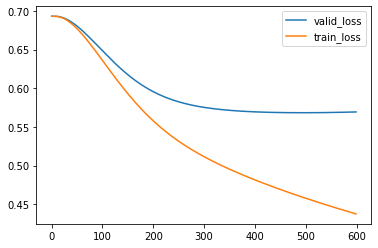

train_loss: 0.43728 | train_metric: 0.87761
valid_loss: 0.56934 | valid_metric: 0.75747
test_loss:  0.56296 | test_metric:  0.76920
CPU times: user 11min 4s, sys: 1min 6s, total: 12min 11s
Wall time: 3min 28s


In [4]:
%%time

EMBEDDING_DIM = 8
LEARNING_RATE = 1e-4
REGULARIZATION = 1e-6
BATCH_SIZE = 4096
EPOCH = 600
TRIAL = 100

lfm = LatentFactorModel(field_dims, EMBEDDING_DIM).to(device)
optimizer = optim.Adam(lfm.parameters(), lr=LEARNING_RATE, weight_decay=REGULARIZATION)
criterion = nn.BCELoss()

trainer = Trainer(lfm, optimizer, criterion, BATCH_SIZE, task=task)
trainer.train(train_X, train_y, epoch=EPOCH, trials=TRIAL, valid_X=valid_X, valid_y=valid_y)
test_loss, test_metric = trainer.test(test_X, test_y)
print('test_loss:  {:.5f} | test_metric:  {:.5f}'.format(test_loss, test_metric))
